## Arianna Varuolo-Clarke 
### RCES Final Project 
### Exploring the stationarity of tropical pacific teleconnections over South America

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%matplotlib inline
import cftime
cftime.__version__

'1.0.2.1'

## Get the data from Ingrid that we need

### SST data
I use xarrays open dataset function to open the dataset, then I rename the variables to be a little more intuitive. I use the fix_calendar function to be corrected with the proper calendar name so that the time is in datetime, provided by Ryan in class, and then I select the time period from 1856 - 2012 for comparison with the geopotential height data which starts in 1856.

In [2]:
def fix_calendar(ds, timevar='time'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

In [3]:
ds = xr.open_dataset('http://kage.ldeo.columbia.edu:81/expert/SOURCES/.LDEO/.ClimateGroup/.PROJECTS/.CCM3/.goga/.sst_goga_1856-2013-1.nc/dods', decode_times = False)
ds = ds.rename({'Y': 'lat', 'X':'lon', 'Z': 'lev', 'T': 'time'})
ds = fix_calendar(ds)
ds = xr.decode_cf(ds)
ds = ds.sel(time=slice('1856-01-01', '2012-12-16'))
ds

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 1, lon: 128, time: 1884)
Coordinates:
  * lat      (lat) float32 -87.86 -85.07079 -82.28159 ... 85.07079 87.86
  * lon      (lon) float32 0.0 2.812598 5.625197 ... 351.5748 354.3874 357.2
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    sst      (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

### Geopotential height data
Follow the same steps for opening the data set, except here I don't have to slice the time. 

In [4]:
ds_hgt = xr.open_dataset('http://kage.ldeo.columbia.edu:81/SOURCES/.LDEO/.ClimateGroup/.PROJECTS/.CCM3/.goga/.atm-mean/.PLD/.Z3.nc/.Z3/dods', decode_times = False)
ds_hgt = ds_hgt.rename({'Y': 'lat', 'X':'lon', 'P': 'pres', 'T': 'time'})
ds_hgt = fix_calendar(ds_hgt)
ds_hgt = xr.decode_cf(ds_hgt)
ds_hgt

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, pres: 17, time: 1884)
Coordinates:
  * pres     (pres) float32 1000.0 925.0 850.0 700.0 ... 50.0 30.0 20.0 10.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    Z3       (time, pres, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

### Calculate Nino 3.4 (170°W - 120°W, 5°N - 5°S) SST index
### Function to remove mean (create anomaly)

In [5]:
def remove_time_mean(x):
    return x - x.mean(dim = 'time')

### Calculate global anomaly of SST

In [6]:
sst_anom = ds.groupby('time.month').apply(remove_time_mean)
sst_anom

<xarray.Dataset>
Dimensions:  (lat: 64, lev: 1, lon: 128, time: 1884)
Coordinates:
  * lat      (lat) float32 -87.86 -85.07079 -82.28159 ... 85.07079 87.86
  * lon      (lon) float32 0.0 2.812598 5.625197 ... 351.5748 354.3874 357.2
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    sst      (time, lev, lat, lon) float32 -1.9073486e-06 ... 8.34465e-07
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Select NINO 3.4 region

In [7]:
sst_anom_region  = sst_anom.sst.sel(lon = slice(190, 240), lat = slice(-5, 5))
sst_anom_region

<xarray.DataArray 'sst' (time: 1884, lev: 1, lat: 4, lon: 18)>
array([[[[ 1.157457, ...,  0.413309],
         ...,
         [ 1.170076, ...,  0.510164]]],


       ...,


       [[[ 0.66568 , ..., -0.073584],
         ...,
         [ 0.355263, ...,  0.632456]]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -4.18381 -1.394603 1.394603 4.18381
  * lon      (lon) float32 191.2567 194.0693 196.8819 ... 236.2583 239.0709
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16

### Take mean over region to be used for correlations later

In [10]:
sst_index4corr = sst_anom_region.mean(dim = ('lon', 'lat'))
sst_index4corr

<xarray.DataArray 'sst' (time: 1884, lev: 1)>
array([[ 1.162963],
       [ 0.951042],
       [ 0.794077],
       ...,
       [ 0.351643],
       [ 0.333045],
       [-0.099254]], dtype=float32)
Coordinates:
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16

## Figure 1 
### S. America Climatology of 200 mb geopotential height

In [11]:
hgt_200 = ds_hgt.sel(pres = 200)
hgt_200

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 1884)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    Z3       (time, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

### calculate gloabl anomaly

In [12]:
hgt_anom = hgt_200.groupby('time.month').apply(remove_time_mean)
hgt_anom

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 1884)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    Z3       (time, lat, lon) float32 38.16992 38.214844 ... -6.743164 -6.791992
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [13]:
hgt_climo = hgt_200.mean(dim = 'time')
hgt_climo

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
Data variables:
    Z3       (lat, lon) float32 10639.954 10639.918 ... 11165.377 11165.497

### Plot seasonal climatologies of 200 mb geopotential heights over South America

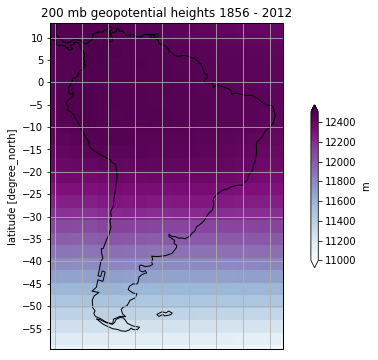

In [14]:
extent = [275, 327, -57, 12] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(figsize = (10, 6)) 
ax = plt.axes(projection = map_proj) # create axis that has the map projection we want 
ax.set_extent(extent) # set extent based on what we have defined above

ax.add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax.add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax.add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 

ax.set_yticks([-55, -50, -45, -40, -35, -30, -25, -20, 
              -15, -10, -5, 0, 5, 10], crs=ccrs.PlateCarree())

cs1 = hgt_climo.Z3.plot(transform = data_proj, vmin = 11000, vmax = 12500, cmap = 'BuPu', add_colorbar = False)
ax.gridlines();
ax.set_title('200 mb geopotential heights 1856 - 2012');

clabel = plt.colorbar(cs1, ax = ax, shrink = 0.5, extend = 'both') 
clabel.set_label('m'); # label color bar with units

#fig.savefig('rces-project_fig1.png')

## Figure 2 
### Patagonia seasonal climatologies of 200 mb geopotential height

### Group by seasons 

In [15]:
hgt_season = hgt_200.groupby('time.season').mean('time')
hgt_season

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, season: 4)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    Z3       (season, lat, lon) float32 10887.308 10887.456 ... 11098.0

### Plot seasonal climatologies of 200 mb geopotential heights over Patagonia during the four seasons

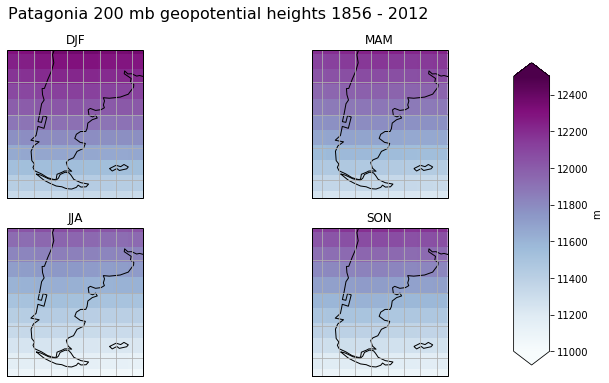

In [16]:
# PLOTTING OVER PATAGONIA
extent = [280, 305, -57, -30] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 6), 
                      subplot_kw = {'projection':map_proj}) # create figure 
fig.suptitle('Patagonia 200 mb geopotential heights 1856 - 2012', fontsize=16)

ax[0,0].set_extent(extent) # set extent based on what we have defined above

ax[0,0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0,0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0,0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 

cs1 = hgt_season.Z3.sel(season = 'DJF').plot(transform = data_proj, vmin = 11000, vmax = 12500, cmap = 'BuPu', ax = ax[0,0], add_colorbar = False);
ax[0,0].gridlines();
ax[0,0].set_title('DJF');

ax[0,1].set_extent(extent) # set extent based on what we have defined above

ax[0,1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0,1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0,1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'MAM').plot(transform = data_proj, vmin = 11000, vmax = 12500, cmap = 'BuPu', ax = ax[0,1], add_colorbar = False); #, cbar_kwargs = {'shrink':0.5}, )
ax[0,1].gridlines();
ax[0,1].set_title('MAM');

ax[1,0].set_extent(extent) # set extent based on what we have defined above

ax[1,0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1,0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1,0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'JJA').plot(transform = data_proj, vmin = 11000, vmax = 12500, cmap = 'BuPu', ax = ax[1,0], add_colorbar = False);
ax[1,0].gridlines();
ax[1,0].set_title('JJA');

ax[1,1].set_extent(extent) # set extent based on what we have defined above

ax[1,1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1,1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1,1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 

cs1 = hgt_season.Z3.sel(season = 'SON').plot(transform = data_proj, vmin = 11000, vmax = 12500, cmap = 'BuPu', ax = ax[1,1], add_colorbar = False);
ax[1,1].gridlines();
ax[1,1].set_title('SON');

cbar_ax = fig.add_axes([0.91, 0.15, 0.05, 0.7])
clabel = fig.colorbar(cs1, cax=cbar_ax, extend = 'both')
clabel.set_label('m'); # label color bar with units

#fig.savefig('rces-project_fig2.png')

## Figure 3 
### Central Andes seasonal climatologies of 200 mb geopotential height

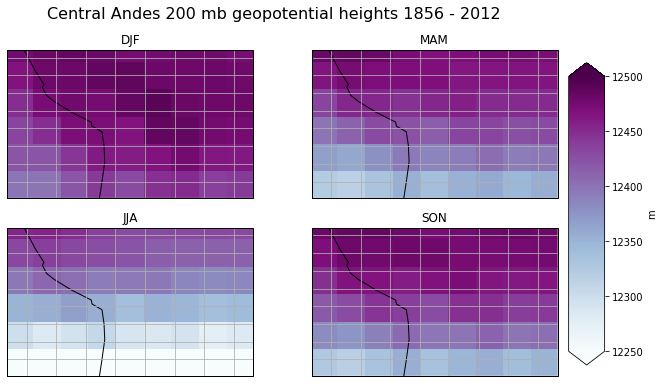

In [17]:
extent = [280, 305, -25, -10] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10, 6), 
                      subplot_kw = {'projection':map_proj}) # create figure 
fig.suptitle('Central Andes 200 mb geopotential heights 1856 - 2012', fontsize=16)

ax[0,0].set_extent(extent) # set extent based on what we have defined above

ax[0,0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0,0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0,0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'DJF').plot(transform = data_proj, vmin = 12250, vmax = 12500, cmap = 'BuPu', ax = ax[0,0], add_colorbar = False); #, cbar_kwargs = {'shrink':0.5}, )
ax[0,0].gridlines();
ax[0,0].set_title('DJF');

ax[0,1].set_extent(extent) # set extent based on what we have defined above

ax[0,1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0,1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0,1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'MAM').plot(transform = data_proj, vmin = 12250, vmax = 12500, cmap = 'BuPu', ax = ax[0,1], add_colorbar = False);
ax[0,1].gridlines();
ax[0,1].set_title('MAM');

ax[1,0].set_extent(extent) # set extent based on what we have defined above

ax[1,0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1,0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1,0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'JJA').plot(transform = data_proj, vmin = 12250, vmax = 12500, cmap = 'BuPu', ax = ax[1,0], add_colorbar = False);
ax[1,0].gridlines();
ax[1,0].set_title('JJA');

ax[1,1].set_extent(extent) # set extent based on what we have defined above

ax[1,1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1,1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1,1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs1 = hgt_season.Z3.sel(season = 'SON').plot(transform = data_proj, vmin = 12250, vmax = 12500, cmap = 'BuPu', ax = ax[1,1], add_colorbar = False);
ax[1,1].gridlines();
ax[1,1].set_title('SON');

cbar_ax = fig.add_axes([0.91, 0.15, 0.05, 0.7])
clabel = fig.colorbar(cs1, cax=cbar_ax, extend = 'both')
clabel.set_label('m'); # label color bar with units

#fig.savefig('rces-project_fig3.png')

## Figure 4 
### SST & Height correlation for Patagonia 

In [18]:
sst_index4corr

<xarray.DataArray 'sst' (time: 1884, lev: 1)>
array([[ 1.162963],
       [ 0.951042],
       [ 0.794077],
       ...,
       [ 0.351643],
       [ 0.333045],
       [-0.099254]], dtype=float32)
Coordinates:
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16

In [19]:
hgt_anom

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 1884)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1856-01-16 1856-02-16 ... 2012-12-16
Data variables:
    Z3       (time, lat, lon) float32 38.16992 38.214844 ... -6.743164 -6.791992
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Functions to calculate covariance and correlation from class 

In [20]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

### Correlate height anomaly and SST index 

In [21]:
sst_hgt_cor = correlation(hgt_anom.Z3, sst_index4corr, dims='time')
sst_hgt_cor

<xarray.DataArray (lat: 64, lon: 128, lev: 1)>
array([[[ 0.359635],
        [ 0.360147],
        ...,
        [ 0.358527],
        [ 0.358966]],

       [[ 0.341818],
        [ 0.344479],
        ...,
        [ 0.337803],
        [ 0.3394  ]],

       ...,

       [[-0.032898],
        [-0.033725],
        ...,
        [-0.030441],
        [-0.031818]],

       [[ 0.017015],
        [ 0.016214],
        ...,
        [ 0.018244],
        [ 0.017447]]])
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * lev      (lev) float32 0.0

### Plot correlation over Patagonia

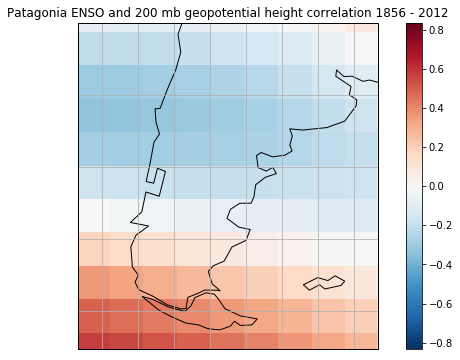

In [22]:
# PLOTTING OVER PATAGONIA
extent = [280, 305, -57, -30] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(figsize = (10, 6))  
ax = plt.axes(projection = map_proj) # create axis that has the map projection we want 
ax.set_extent(extent) # set extent based on what we have defined above

ax.add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax.add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax.add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor.plot(transform = data_proj, ax = ax)
#plt.clabel(cs) # use plt to format the contour labels using clabel, %1.0f tell python to only show string of whole numbers and we added unit
ax.set_title('Patagonia ENSO and 200 mb geopotential height correlation 1856 - 2012');
ax.gridlines();

#fig.savefig('rces-project_fig4.png')

## Figure 5 
### SST & Height correlation for Central Andes

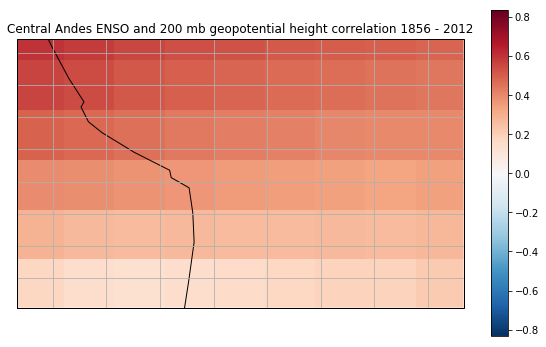

In [23]:
# PLOTTING OVER CENTRAL ANDES 
extent = [280, 305, -25, -10] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(figsize = (10, 6))  
ax = plt.axes(projection = map_proj) # create axis that has the map projection we want 
ax.set_extent(extent) # set extent based on what we have defined above

ax.add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax.add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax.add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor.plot(transform = data_proj, ax = ax)
ax.gridlines();
ax.set_title('Central Andes ENSO and 200 mb geopotential height correlation 1856 - 2012');

#fig.savefig('rces-project_fig5.png')

### Now what happens when we break down the pattern and look at ~30 year chunks of time and the correlation between the NINO 3.4 index and geopotential height ?! 

### In order to do this, let's take two slices of time from hgt_anom.Z3, and sst_index4corr. I have arbitrarily chosen 1875 - 1924 and 1950 - 1999. 

In [24]:
hgt_anom_time1 = hgt_anom.sel(time=slice('1875-01-01', '1924-12-01'))
hgt_anom_time1

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 599)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1875-01-16 1875-02-16 ... 1924-11-16
Data variables:
    Z3       (time, lat, lon) float32 -7.583008 -7.538086 ... -39.336914
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11

In [25]:
hgt_anom_time2 = hgt_anom.sel(time=slice('1950-01-01', '1999-12-01'))
hgt_anom_time2

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 599)
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * time     (time) datetime64[ns] 1950-01-16 1950-02-16 ... 1999-11-16
Data variables:
    Z3       (time, lat, lon) float32 -52.555664 -52.899414 ... -0.43066406
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 1 2 3 4 5 6 7 8 9 10 11

In [26]:
sst_index4corr_time1 = sst_index4corr.sel(time=slice('1875-01-01', '1924-12-01'))
sst_index4corr_time1

<xarray.DataArray 'sst' (time: 599, lev: 1)>
array([[-0.621976],
       [-0.683193],
       [-0.45759 ],
       ...,
       [-0.58447 ],
       [-0.757038],
       [-1.165233]], dtype=float32)
Coordinates:
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1875-01-16 1875-02-16 ... 1924-11-16

In [27]:
sst_index4corr_time2 = sst_index4corr.sel(time=slice('1950-01-01', '1999-12-01'))
sst_index4corr_time2

<xarray.DataArray 'sst' (time: 599, lev: 1)>
array([[-0.95019 ],
       [-1.396947],
       [-1.007979],
       ...,
       [-0.620282],
       [-0.757127],
       [-0.9994  ]], dtype=float32)
Coordinates:
  * lev      (lev) float32 0.0
  * time     (time) datetime64[ns] 1950-01-16 1950-02-16 ... 1999-11-16

In [28]:
sst_hgt_cor_time1 = correlation(hgt_anom_time1.Z3, sst_index4corr_time1, dims='time')
sst_hgt_cor_time1

<xarray.DataArray (lat: 64, lon: 128, lev: 1)>
array([[[0.425121],
        [0.425918],
        ...,
        [0.423558],
        [0.424341]],

       [[0.40308 ],
        [0.406311],
        ...,
        [0.397764],
        [0.399788]],

       ...,

       [[0.023246],
        [0.023149],
        ...,
        [0.024491],
        [0.023518]],

       [[0.084259],
        [0.083549],
        ...,
        [0.085027],
        [0.084505]]])
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * lev      (lev) float32 0.0

In [29]:
sst_hgt_cor_time2 = correlation(hgt_anom_time2.Z3, sst_index4corr_time2, dims='time')
sst_hgt_cor_time2

<xarray.DataArray (lat: 64, lon: 128, lev: 1)>
array([[[ 0.393027],
        [ 0.393426],
        ...,
        [ 0.391862],
        [ 0.392397]],

       [[ 0.373593],
        [ 0.376433],
        ...,
        [ 0.369575],
        [ 0.371152]],

       ...,

       [[-0.064437],
        [-0.065073],
        ...,
        [-0.061982],
        [-0.063304]],

       [[-0.021194],
        [-0.022026],
        ...,
        [-0.019999],
        [-0.020814]]])
Coordinates:
    pres     float32 200.0
  * lat      (lat) float32 -87.8638 -85.09653 -82.31291 ... 85.09653 87.8638
  * lon      (lon) float32 0.0 2.8125 5.625 8.4375 ... 351.5625 354.375 357.1875
  * lev      (lev) float32 0.0

## Figure 6 
### Okay, now let's plot the Patagonia correlations

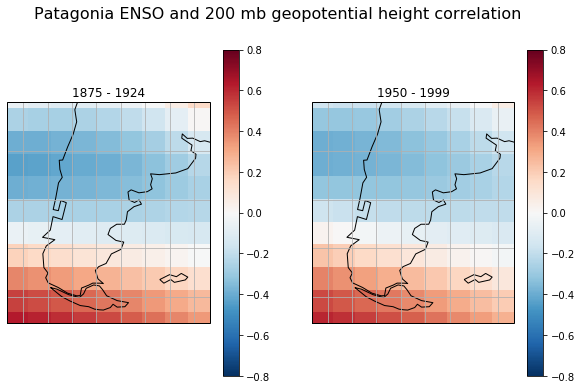

In [30]:
# PLOTTING OVER PATAGONIA
extent = [280, 305, -57, -30] # set extent 
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(ncols = 2, figsize = (10, 6), 
                       subplot_kw = {'projection':map_proj})  
fig.suptitle('Patagonia ENSO and 200 mb geopotential height correlation', fontsize=16)

ax[0].set_extent(extent) # set extent based on what we have defined above

ax[0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor_time1.plot(transform = data_proj, ax = ax[0], vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r', extend = 'neither')
ax[0].gridlines();
ax[0].set_title('1875 - 1924');

ax[1].set_extent(extent) # set extent based on what we have defined above

ax[1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor_time2.plot(transform = data_proj, ax = ax[1], vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r', extend = 'neither')
ax[1].gridlines();
ax[1].set_title('1950 - 1999');

fig.savefig('rces-project_fig6.png')

## Figure 7 
### Now plot the Central Andes correlations

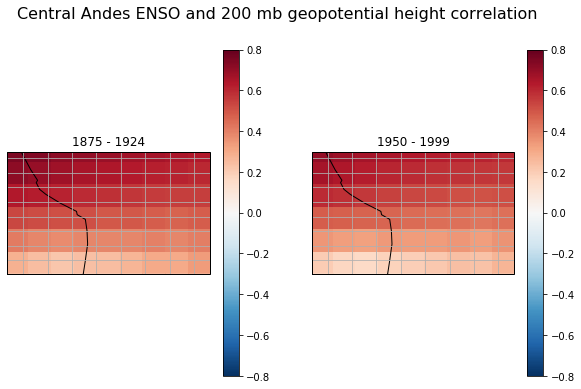

In [31]:
# PLOTTING OVER CENTRAL ANDES 
extent = [280, 305, -25, -10] # set extent
central_lon = np.mean(extent[:2]) # get first two values in extent which are longitudes to calc center lon
central_lat = np.mean(extent[2:]) # get last two values in extent which are latutides to calc center lat

map_proj = ccrs.PlateCarree(central_lon) # this is the project we want our map to be on 
data_proj = ccrs.PlateCarree() # the data is in lat/lon, we can use PlateCarrree 

fig, ax = plt.subplots(ncols = 2, figsize = (10, 6), 
                       subplot_kw = {'projection':map_proj})  
fig.suptitle('Central Andes ENSO and 200 mb geopotential height correlation', fontsize=16)

ax[0].set_extent(extent) # set extent based on what we have defined above

ax[0].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[0].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[0].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor_time1.plot(transform = data_proj, ax = ax[0], vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r', extend = 'neither')
ax[0].gridlines();
ax[0].set_title('1875 - 1924');

ax[1].set_extent(extent) # set extent based on what we have defined above

ax[1].add_feature(cfeature.OCEAN, facecolor = 'w', edgecolor = 'k') # add ocean, make it white 
ax[1].add_feature(cfeature.LAND, facecolor = 'w', edgecolor = 'k') # add land,make it white with black edges
ax[1].add_feature(cfeature.COASTLINE, edgecolor = 'k') # add coastline feature and set color to be white and edgecolor to be black 


cs = sst_hgt_cor_time2.plot(transform = data_proj, ax = ax[1], vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r', extend = 'neither')
ax[1].gridlines();
ax[1].set_title('1950 - 1999');

#fig.savefig('rces-project_fig7.png')